EXTRACTION OF PAPERS THAT HAS GIVEN KEYWORDS

In [1]:
import os
from PyPDF2 import PdfReader

In [2]:
def extract_papers():
    global files 
    wordlist = ['natural language processing','natural language process','natural language processing (nlp)','cognitive computing','cognition']
    for filename in os.listdir(pdf_dir):
        if filename.endswith('.pdf'):
            pdf_path = os.path.join(pdf_dir, filename)
            with open(pdf_path, 'rb') as pdf_file:
                reader = PdfReader(pdf_file)
                page = reader.pages[0]
                for page in reader.pages:
                    text = page.extract_text()
                    lines = text.split('\n')
                    for i, line in enumerate(lines):
                        if line.startswith('Index Terms—'):
                            if i + 1 < len(lines):
                                string = line[12:] + lines[i+1]
                                
                                # Extracting keywords from the string
                                keywords = [word.strip() for word in string.split(',')]
                                print(keywords)
                                
                                
                                # Check if entered words match keywords
                                for keyword in keywords:
                                    keyword_lower = keyword.lower()
                                    for word in wordlist:
                                        if keyword_lower == word.lower():
                                            print("match found")
                                            files.append(filename)
                                            # Print the list of files that match the entered keywords
                                            print(files)


In [3]:
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.text_rank import TextRankSummarizer
from sumy.nlp.stemmers import Stemmer

In [4]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize

Summarization using extractive method

In [5]:
def extractive(text):
    parser = PlaintextParser.from_string(text, Tokenizer("english"))
    summarizer = TextRankSummarizer(Stemmer("english"))
    summary = summarizer(parser.document, 8)
    return "\n".join(str(sentence) for sentence in summary)

Summarization using abstractive method

In [6]:
def abstractive(text):
    sentences = sent_tokenize(text)
    stop_words = set(stopwords.words("english"))
    filtered_sentences = [sentence for sentence in sentences if sentence.lower() not in stop_words]
    summary_sentences = filtered_sentences[:10]
    summary = " ".join(summary_sentences)
    return summary

Summarization using Bart

In [7]:
def bart(text, output_file="abstractive_summary.txt"):
    # Load the summarizer
    summarizer = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')
    tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')

    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", max_length=1024, truncation=True)

    # Generate the summary
    summary_ids = summarizer.generate(inputs["input_ids"], max_length=150, min_length=50, length_penalty=2.0, num_beams=4, early_stopping=True)

    # Decode and save the summary to the output file
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    with open(output_file, 'w', encoding='utf-8') as output_file:
        output_file.write(summary)

    print(f"Abstractive summary has been saved to {output_file}")

Function to generate summaries. Methods used 1. Extractive 2. Abstractive

In [8]:
def generate_summaries():
    # Initializing an empty string to store all summaries
    all_summaries = ""
    summary_file = "./summary_file.txt"
    # Iterating through the files
    for filename in os.listdir(pdf_dir):
        if filename.endswith('.pdf'):
            pdf_path = os.path.join(pdf_dir, filename)
            with open(pdf_path, 'rb') as pdf_file:
                reader = PdfReader(pdf_file)

                # Initializing an empty string for the current summary
                current_summary = ""

                for page_number, page in enumerate(reader.pages):
                    # Extract text from the current page
                    text = page.extract_text()

                    # Perform abstractive summarization
                    abstractive_summary = abstractive(text)
                    current_summary += f"Abstractive Summary (Page {page_number + 1}):\n{abstractive_summary}\n\n"

                    # Perform extractive summarization
                    extractive_summary = extractive(text)
                    current_summary += f"Extractive Summary (Page {page_number + 1}):\n{extractive_summary}\n\n"

                # Add the current summary to the overall summaries
                all_summaries += f"Summary for {filename}:\n{current_summary}\n"

    # Save all summaries to a file
    with open(summary_file, 'w', encoding='utf-8') as summary_file:
        summary_file.write(all_summaries)

    print("Summaries have been saved to", summary_file)

Function to get list of papers with matched keywords

In [9]:
def get_matched_papers():
    global files
    for filename in files:
        print(filename + '\n')

In [10]:
from gensim.summarization import summarize

D:\Programfiles\anaconda\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Function to summarize combined text from all papers - method used is extractive

In [11]:
def summarize_combined_text(output_file="combined_summary.txt", summary_file="summary.txt"):
    # Initializing an empty string to store the combined text
    
    global files
    combined_text = ""

    # Iterate through the files and concatenate the text
    for filename in files:
        pdf_path = os.path.join(pdf_dir, filename)
        with open(pdf_path, 'rb') as pdf_file:
            reader = PdfReader(pdf_file)

            for page_number, page in enumerate(reader.pages):
                combined_text += page.extract_text()

    # If a summary file is provided, read its content and append it to the combined text
    if summary_file and os.path.exists(summary_file):
        with open(summary_file, 'r', encoding='utf-8') as summary_file:
            combined_text += summary_file.read()

    # Summarize the combined text
    summary = summarize(combined_text)

    # Save the summarized text to the output file
    with open(output_file, 'w', encoding='utf-8') as output_file:
        output_file.write(summary)

    print(f"Combined Summarized Text has been saved to {output_file}")

In [12]:
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lsa import LsaSummarizer

Function to summarize combined text from all papers - method used is extractive. No of sentences for summary can be changed

In [13]:
def extractive_combined_summary(sentences_count, output_file="extractive_summary.txt"):
    # Combined text of all PDFs
    combined_text = ""
    global files
    
    # Iterate through the files and concatenate the text
    for filename in files:
        pdf_path = os.path.join(pdf_dir, filename)
        with open(pdf_path, 'rb') as pdf_file:
            reader = PdfReader(pdf_file)

            for page_number, page in enumerate(reader.pages):
                combined_text += page.extract_text()

    # Choose the language
    language = "english"

    # Initialize the parser and tokenizer
    parser = PlaintextParser.from_string(combined_text, Tokenizer(language))

    # Initialize the summarizer (LSA algorithm)
    summarizer = LsaSummarizer()

    # Get the summary with the desired number of sentences
    summary = summarizer(parser.document, sentences_count=sentences_count)

    # Write the extractive summary to the output file
    with open(output_file, 'w', encoding='utf-8') as output_file:
        for sentence in summary:
            print('hello')
            output_file.write(str(sentence) + "\n")

    print(f"Extractive summary has been saved to {output_file.name}")

Function to summarize combined text from all papers - method used is abstractive. Length of the summary can be changed by changing value of max_length

In [14]:
from transformers import BartTokenizer, BartForConditionalGeneration

In [15]:
def abstractive_combined_summary( model_name="facebook/bart-large-cnn", output_file="abstractive_combined_text_summary.txt"):
    # Combined text of all PDFs
    combined_text = ""
    global files
    
    # Iterate through the files and concatenate the text
    for filename in files:
        pdf_path = os.path.join(pdf_dir, filename)
        with open(pdf_path, 'rb') as pdf_file:
            reader = PdfReader(pdf_file)

            for page_number, page in enumerate(reader.pages):
                combined_text += page.extract_text()

    # Load the pre-trained BART model and tokenizer
    model = BartForConditionalGeneration.from_pretrained(model_name)
    tokenizer = BartTokenizer.from_pretrained(model_name)

    # Tokenize the input text
    inputs = tokenizer(combined_text, return_tensors="pt", max_length=1024, truncation=True)

    # Generate the abstractive summary
    summary_ids = model.generate(inputs["input_ids"], max_length=150, min_length=50, length_penalty=2.0, num_beams=4, early_stopping=True)

    # Decode and save the abstractive summary to the output file
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    with open(output_file, 'w', encoding='utf-8') as output_file:
        print('hello')
        output_file.write(summary)

    print(f"Abstractive summary has been saved to {output_file}")

In [16]:
def read_text_files(directory_path):
    text_data = {}
    # Get a list of all text files in the directory
    global files
    
    text_files = [file for file in os.listdir(directory_path) if file.endswith(".txt")]

    if not text_files:
        print("No text files found in the specified directory.")
        return text_data

    print("Text Files in the Directory:")
    for i, text_file in enumerate(text_files, start=1):
        print(f"{i}. {text_file}")

    # Get user input to choose a file to open
    while True:
        try:
            choice = int(input("Enter the number of the file you want to open (or 0 to exit): "))
            if 0 <= choice <= len(text_files):
                break
            else:
                print("Invalid choice. Please enter a valid number.")
        except ValueError:
            print("Invalid input. Please enter a number.")

    if choice == 0:
        return text_data

    selected_file = text_files[choice - 1]
    selected_file_path = os.path.join(directory_path, selected_file)

    # Read the content of the selected file
    with open(selected_file_path, 'r', encoding='utf-8') as file:
        print('hello')
        content = file.read()

    text_data[selected_file] = content
    return text_data

In [17]:
def main():
    while True:
        print("\nMenu:")
        print("1. Generate Summaries for Multiple Files")
        print("2. Get Matched Papers based on Keywords")
        print("3. Summarize Combined Text")
        print("4. Extractive Summarization of PDFs")
        print("5. Abstractive Summarization of PDFs (BART)")
        print("6. Read Text Files in a Directory")
        print("7. Exit")

        choice = input("Enter your choice (1-7): ")

        if choice == '1':
            generate_summaries()
        elif choice == '2':
            print("List of matched papers with the keywords")
            get_matched_papers()
        elif choice == '3':
            summarize_combined_text()
        elif choice == '4':
            sentences_count = int(input("Enter the number of sentences for extractive summarization: "))
            extractive_combined_summary(sentences_count)
        elif choice == '5':
            abstractive_combined_summary()
        elif choice == '6':
            text_contents = read_text_files(os.getcwd())
            for filename, content in text_contents.items():
                print(f"Content of {filename}:\n{content}\n")
        elif choice == '7':
            print("Exiting the program.")
            break
        else:
            print("Invalid choice. Please enter a number between 1 and 7.")

pdf_dir = os.getcwd()
inner_folder_name = "Papers"
pdf_dir = os.path.join(pdf_dir, inner_folder_name)
pdf_dir2= os.path.join(pdf_dir,'Papers2')
pdf_dir3= os.path.join(pdf_dir,'Papers3')
files = []
files2= [] 
files3= []
extract_papers()

if __name__ == "__main__":
    main()

['Attention mechanism', 'deep reinforcement learn-ing (RL)', 'natural language processing (NLP)', 'neural networks.']
match found
['paper1.pdf']
['IoV', 'SAGIN', 'Natural Language Process', 'Searchable Encryption', 'Data Privacy.F']
match found
['paper1.pdf', 'paper2.pdf']
['Knowledge Graph', 'Active Learning', 'Knowledge Graph Schema Expansion', 'Relation Extraction.F']
['Natural language processing', 'Sentiment analy-sis', 'Computer games', 'Steam.']
match found
['paper1.pdf', 'paper2.pdf', 'paper4.pdf']
['Clustering', 'Natural Language Processing', 'Main-tenance records', 'Taxonomy.']
match found
['paper1.pdf', 'paper2.pdf', 'paper4.pdf', 'paper5.pdf']

Menu:
1. Generate Summaries for Multiple Files
2. Get Matched Papers based on Keywords
3. Summarize Combined Text
4. Extractive Summarization of PDFs
5. Abstractive Summarization of PDFs (BART)
6. Read Text Files in a Directory
7. Exit
Enter your choice (1-7): 7
Exiting the program.


In [19]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


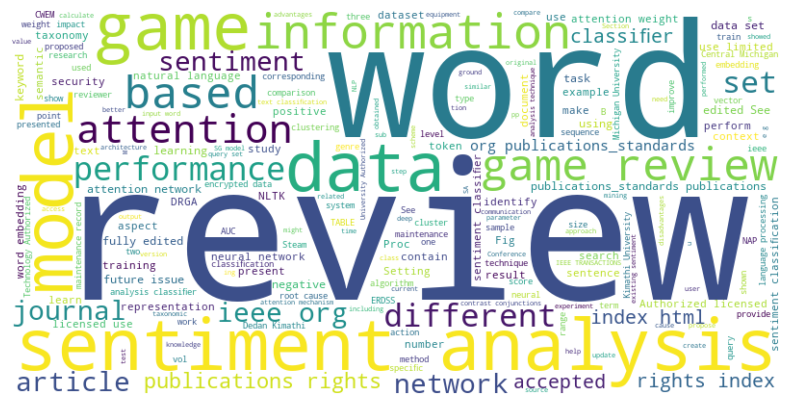

In [20]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def generate_wordcloud_from_file(file_path):
    # Read the contents of the text file
    with open(file_path, 'r', encoding='utf-8') as file:
        text_data = file.read()

    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

text_file_path = "D:/MIT-WPU/5th sem/CCNLP/Project/combined_summary.txt"  # Replace with the actual path to your text file
generate_wordcloud_from_file(text_file_path)


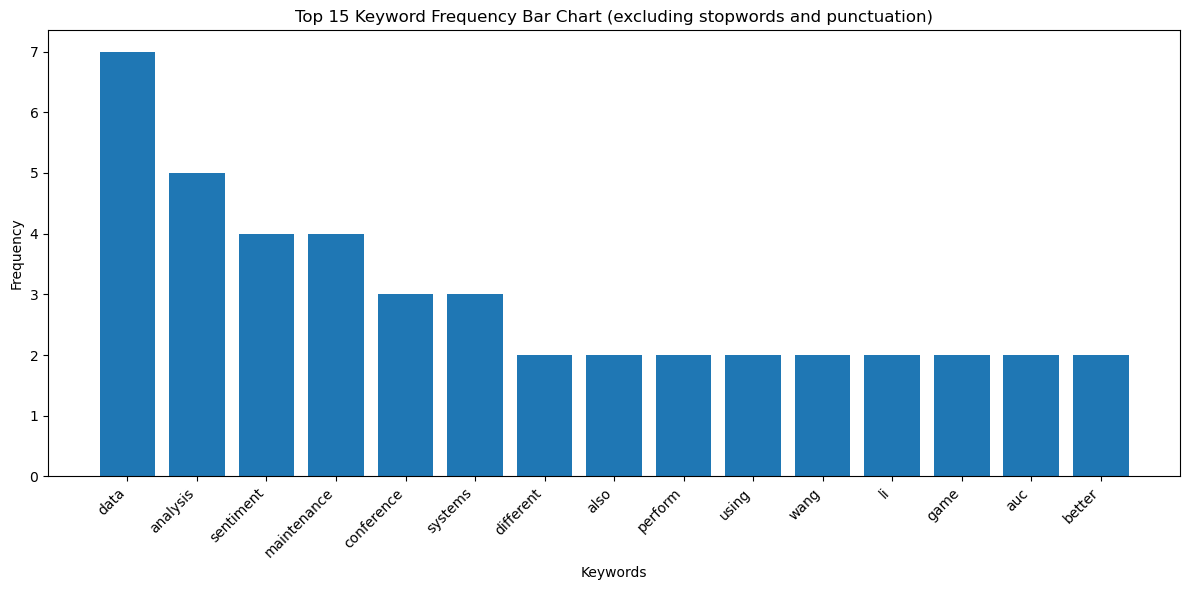

In [21]:
import matplotlib.pyplot as plt
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

def generate_word_frequency_bar_chart(file_path, top_n=15):
    # Read the contents of the text file
    with open(file_path, 'r', encoding='utf-8') as file:
        text_data = file.read()

    # Tokenize the text
    words = word_tokenize(text_data)

    # Filter out stopwords and non-alphabetic words
    stop_words = set(stopwords.words('english'))
    filtered_words = [word.lower() for word in words if word.lower() not in stop_words and word.isalpha()]

    # Calculate word frequency
    word_freq = Counter(filtered_words)

    # Select the top N words
    top_words = dict(sorted(word_freq.items(), key=lambda item: item[1], reverse=True)[:top_n])

    plt.figure(figsize=(12, 6))
    plt.bar(top_words.keys(), top_words.values())
    plt.xlabel('Keywords')
    plt.ylabel('Frequency')
    plt.title('Top {} Keyword Frequency Bar Chart (excluding stopwords and punctuation)'.format(top_n))
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
text_file_path = "D:/MIT-WPU/5th sem/CCNLP/Project/extractive_summary.txt"  # Replace with the actual path to your text file
generate_word_frequency_bar_chart(text_file_path)


In [22]:
import textstat

def calculate_readability_from_file(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            text = file.read()
        grade_level = textstat.flesch_kincaid_grade(text)
        return grade_level
    except Exception as e:
        print(f"Error calculating readability: {e}")
        return None

# Example usage:
generated_summary_file = "D:/MIT-WPU/5th sem/CCNLP/Project/combined_summary.txt"  
grade_level = calculate_readability_from_file(generated_summary_file)

if grade_level is not None:
    print({grade_level})
else:
    print("Readability calculation failed.")


{15.1}


In [23]:
import textstat

def calculate_readability_from_file(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            text = file.read()
        grade_level = textstat.flesch_kincaid_grade(text)
        return grade_level
    except Exception as e:
        print(f"Error calculating readability: {e}")
        return None

# Example usage:
generated_summary_file = "D:/MIT-WPU/5th sem/CCNLP/Project/extractive_summary.txt"  # Replace with the actual path to your generated summary file

grade_level = calculate_readability_from_file(generated_summary_file)

if grade_level is not None:
    print({grade_level})
else:
    print("Readability calculation failed.")


{11.4}


In [24]:
import textstat

def calculate_readability_from_file(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            text = file.read()
        grade_level = textstat.flesch_kincaid_grade(text)
        return grade_level
    except Exception as e:
        print(f"Error calculating readability: {e}")
        return None

# Example usage:
generated_summary_file = "D:/MIT-WPU/5th sem/CCNLP/Project/abstractive_combined_text_summary.txt"  # Replace with the actual path to your generated summary file

grade_level = calculate_readability_from_file(generated_summary_file)

if grade_level is not None:
    print({grade_level})
else:
    print("Readability calculation failed.")


{10.7}


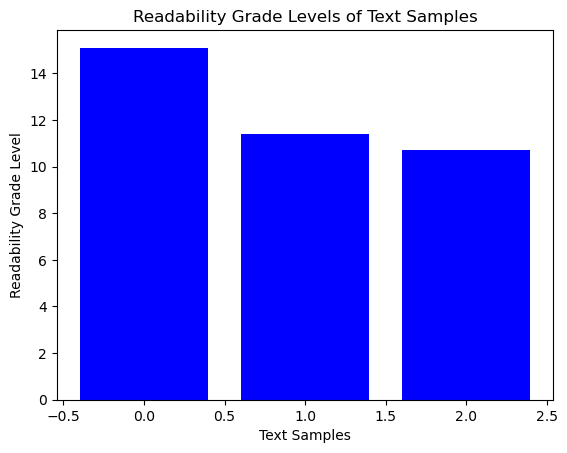

In [25]:
import matplotlib.pyplot as plt

def plot_grade_levels(grade_levels):
    plt.bar(range(len(grade_levels)), grade_levels, color='blue')
    plt.xlabel('Text Samples')
    plt.ylabel('Readability Grade Level')
    plt.title('Readability Grade Levels of Text Samples')
    plt.show()

# Example usage:
# Replace 'grade_levels' with the actual list of Flesch-Kincaid Grade Levels for your text samples
grade_levels = [15.1, 11.4, 10.7]

plot_grade_levels(grade_levels)


In [2]:
pip install rouge

Note: you may need to restart the kernel to use updated packages.


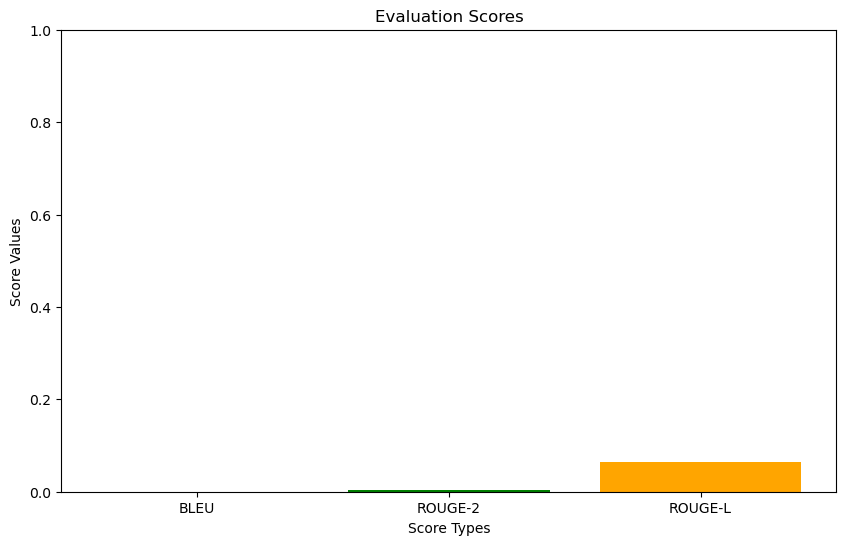

In [10]:
from rouge import Rouge

def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return file.read()

def calculate_rouge(reference, candidate):
    rouge = Rouge()
    rouge_scores = rouge.get_scores(candidate, reference)[0]
    return rouge_scores['rouge-1']['f'], rouge_scores['rouge-2']['f'], rouge_scores['rouge-l']['f']

def compare_summaries(extractive_summary, abstractive_summary):
    rouge1_f_e, rouge2_f_e, rougel_f_e = calculate_rouge(extractive_summary, abstractive_summary)
    rouge1_f_a, rouge2_f_a, rougel_f_a = calculate_rouge(abstractive_summary, extractive_summary)

    print("ROUGE Scores for Extractive Summary:")
    print(f"ROUGE-1 F-score: {rouge1_f_e}")
    print(f"ROUGE-2 F-score: {rouge2_f_e}")
    print(f"ROUGE-L F-score: {rougel_f_e}")

    print("\nROUGE Scores for Abstractive Summary:")
    print(f"ROUGE-1 F-score: {rouge1_f_a}")
    print(f"ROUGE-2 F-score: {rouge2_f_a}")
    print(f"ROUGE-L F-score: {rougel_f_a}")

    if rouge1_f_e > rouge1_f_a and rouge2_f_e > rouge2_f_a and rougel_f_e > rougel_f_a:
        print("\nExtractive Summary is better.")
    elif rouge1_f_a > rouge1_f_e and rouge2_f_a > rouge2_f_e and rougel_f_a > rougel_f_e:
        print("\nAbstractive Summary is better.")
    else:
        print("\nBoth summaries are comparable.")

# Example usage:
extractive_file_path = "extractive_summary.txt"  # Replace with the actual path to your extractive summary file
abstractive_file_path = "abstractive_combined_text_summary.txt"  # Replace with the actual path to your abstractive summary file

extractive_summary = read_text_file(extractive_file_path)
abstractive_summary = read_text_file(abstractive_file_path)

compare_summaries(extractive_summary, abstractive_summary)


ROUGE Scores for Extractive Summary:
ROUGE-1 F-score: 0.06332453624689337
ROUGE-2 F-score: 0.004056793309168929
ROUGE-L F-score: 0.06332453624689337

ROUGE Scores for Abstractive Summary:
ROUGE-1 F-score: 0.06332453624689337
ROUGE-2 F-score: 0.004056793309168929
ROUGE-L F-score: 0.06332453624689337

Both summaries are comparable.


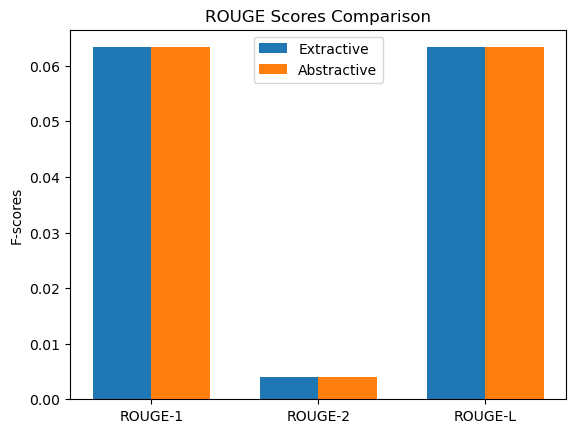

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_rouge_scores(rouge1_f_e, rouge2_f_e, rougel_f_e, rouge1_f_a, rouge2_f_a, rougel_f_a):
    labels = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']
    
    extractive_scores = [rouge1_f_e, rouge2_f_e, rougel_f_e]
    abstractive_scores = [rouge1_f_a, rouge2_f_a, rougel_f_a]

    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, extractive_scores, width, label='Extractive')
    rects2 = ax.bar(x + width/2, abstractive_scores, width, label='Abstractive')

    ax.set_ylabel('F-scores')
    ax.set_title('ROUGE Scores Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    plt.show()

# Example usage:
rouge1_f_e, rouge2_f_e, rougel_f_e = calculate_rouge(extractive_summary, abstractive_summary)
rouge1_f_a, rouge2_f_a, rougel_f_a = calculate_rouge(abstractive_summary, extractive_summary)

visualize_rouge_scores(rouge1_f_e, rouge2_f_e, rougel_f_e, rouge1_f_a, rouge2_f_a, rougel_f_a)
